In [1]:
%load_ext autoreload
%autoreload 2

# Import 

In [2]:
from bosonic_jax import Qubit, GKPQubit, execute, BosonicRegister, BosonicCircuit, PhaseRotationGate, \
                    DisplaceGate, NumSplitCDGate, QubitRotationGate, NumDepQubitRotationGate, CDGate
import numpy as np
import matplotlib.pyplot as plt

# Create Bosonic Circuit 

In [3]:
# Circuit containing 1 cavity and 1 qubit
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)

# set up circuit
bcirc.reset() # initialize each qubit in |+z>
bcirc.x(0) # added to gates list
bcirc.x(1) # added to gates list

%timeit results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"

16.7 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


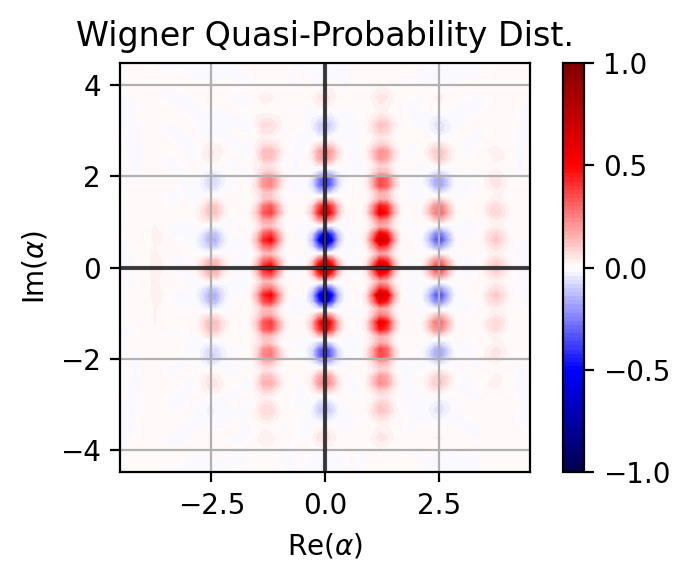

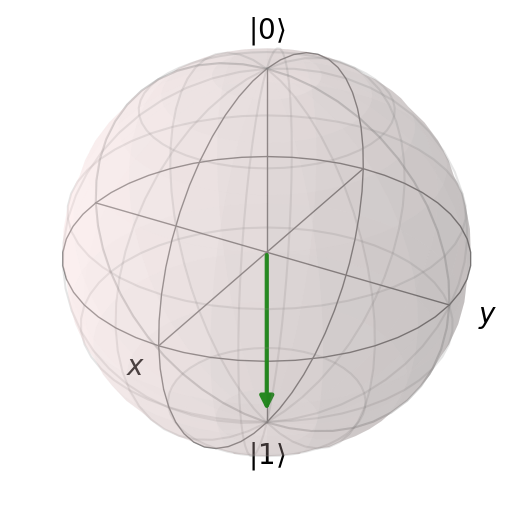

<Figure size 640x480 with 0 Axes>

In [4]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
results.plot(bcirc, 0)
results.plot(bcirc, 1)

# Custom Gates

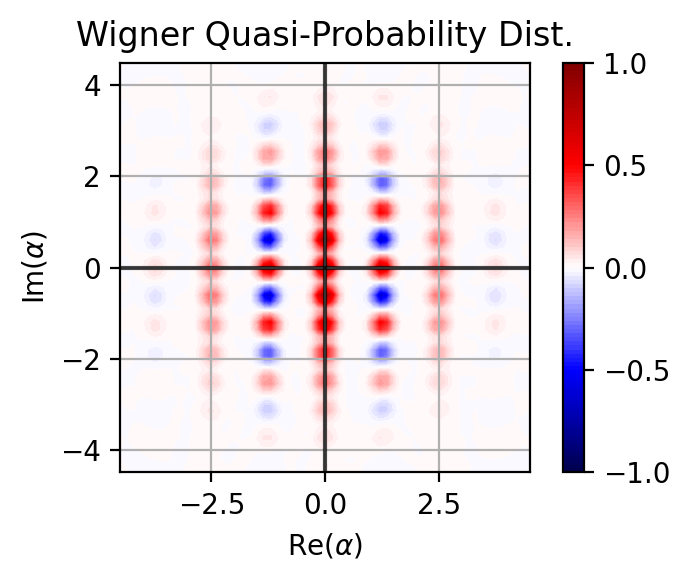

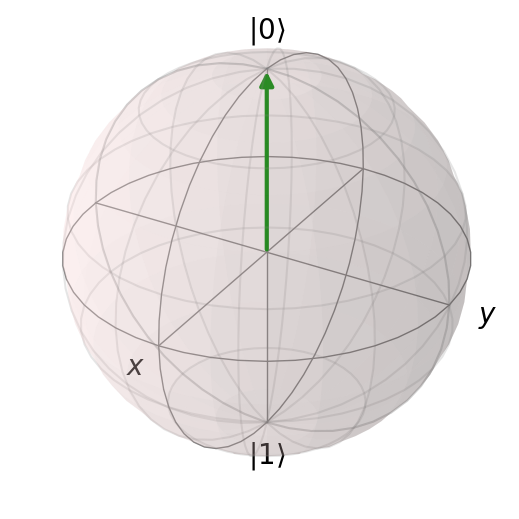

<Figure size 640x480 with 0 Axes>

In [5]:
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)
bcirc.plot(0)
bcirc.plot(1)

In [6]:
breg = BosonicRegister([GKPQubit(),Qubit()]) # [q0,q1]
bcirc = BosonicCircuit(breg)

bcirc.x(1) # add an X Gate on q1
bcirc.add(PhaseRotationGate, 0, {"phi": np.pi/4}) 
bcirc.add(CDGate, (0,1), {"beta": 1}) # q0 is the control

%timeit results = execute(bcirc, "unitary_jax")

24.5 µs ± 440 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


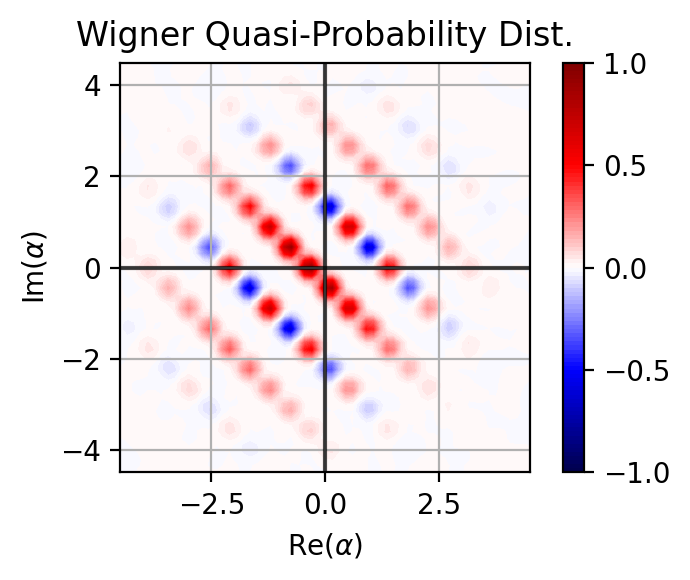

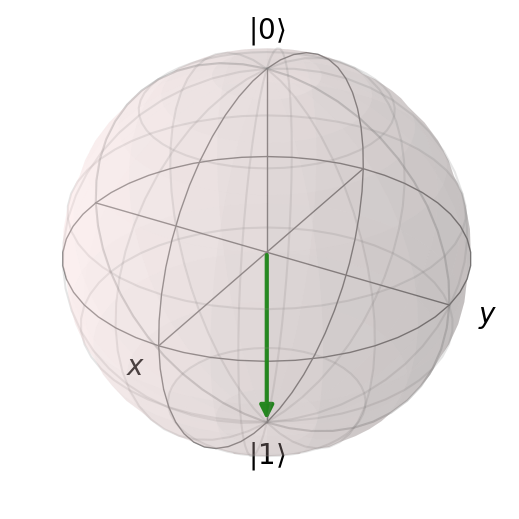

<Figure size 640x480 with 0 Axes>

In [7]:
results = execute(bcirc, "unitary_jax")

results.plot(bcirc, 0) # plot q0
results.plot(bcirc, 1) # plot q1

In [8]:
%timeit results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"

24.6 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


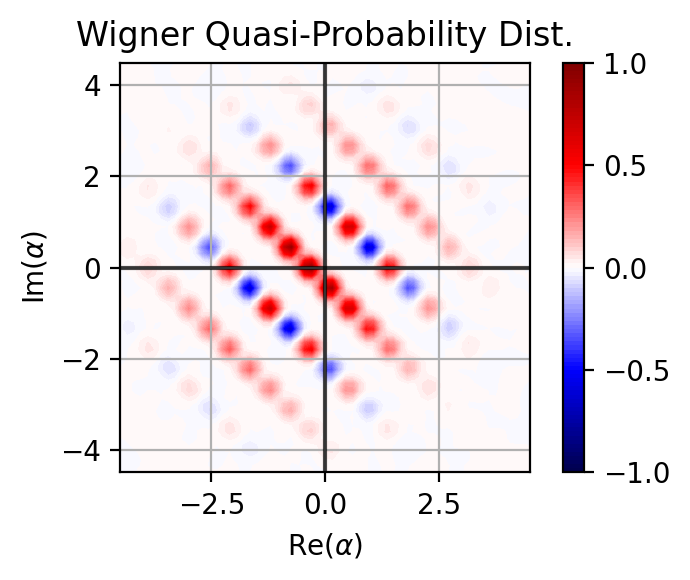

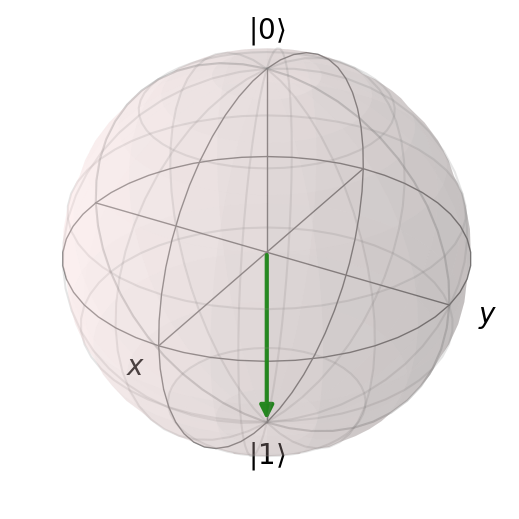

<Figure size 640x480 with 0 Axes>

In [9]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
results.plot(bcirc, 0)
results.plot(bcirc, 1)

# Hamiltonian Simulations

## Demo: Number-Split Conditional Displacement

In [13]:
import jaxquantum as jqt
from jax import device_put
import jax.numpy as jnp

In [15]:
# parameters & constants
π = jnp.pi ; χ = 2*π * 2 ; K = 2*π * 0
beta = jnp.sqrt(2)*2*(2.5 + 2j)
N = 50

# set up operators
a = jqt.destroy(N)
a_dag = jqt.dag(a)
I_q = jnp.eye(2)
I_a = jnp.eye(N)
aq = jnp.kron(a, I_q)
aq_dag = jqt.dag(aq)

# base hamiltonian
H0 = jnp.kron(χ*a_dag@a, jqt.sigmaz()) + (K/2)*aq_dag @ aq_dag @ aq @ aq
ts = jnp.linspace(0.0, 2*π/χ, 251)

# set up new circuit
breg = BosonicRegister([GKPQubit(params={"N":N}),Qubit()]) # create register
bcirc = BosonicCircuit(breg) # create circuit
bcirc.add(NumSplitCDGate, (0,1),{"beta": beta, "chi": χ}, ts) # add gate
results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[]) # run circuit simulation
results.calc_expect(aq, "aq")
%timeit results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[])

426 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


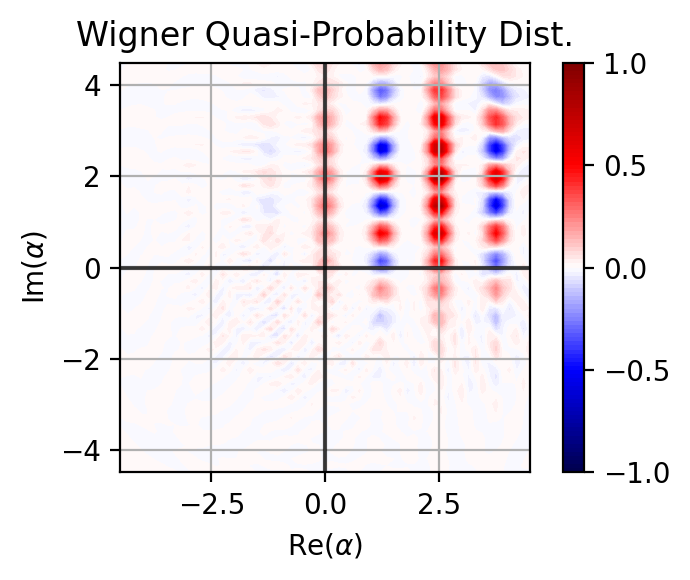

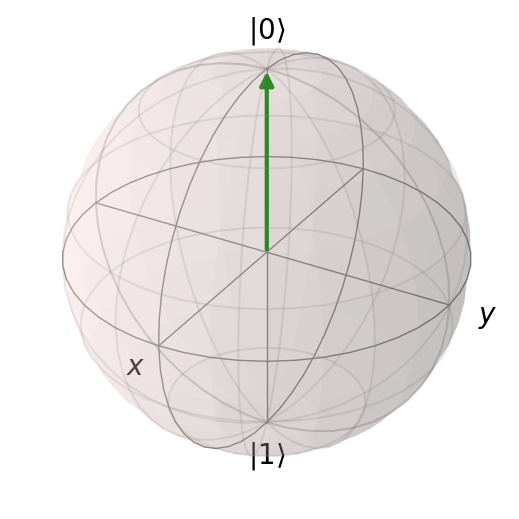

<Figure size 640x480 with 0 Axes>

In [16]:
results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[])
results.plot(bcirc, 0)
results.plot(bcirc, 1)

In [17]:
results.calc_expect(aq, "aq")

In [18]:
def plot_trajectory(ts, expectation):
    fig, axs = plt.subplots(1,2, dpi=200, figsize=(8,3))
    axs[0].plot(np.real(expectation), np.imag(expectation))
    axs[0].set_xlabel(r"$\langle \hat{q}\rangle$")
    axs[0].set_ylabel(r"$\langle \hat{p}\rangle$")
    
    axs[1].plot(ts, np.real(expectation), label=r"$\langle \hat{q}\rangle$")
    axs[1].plot(ts, np.imag(expectation), label=r"$\langle \hat{p}\rangle$")
    axs[1].set_ylabel(r'Expectation of quadratures')
    axs[1].set_xlabel('Time')
    axs[1].legend()

    fig.tight_layout()
    plt.show()

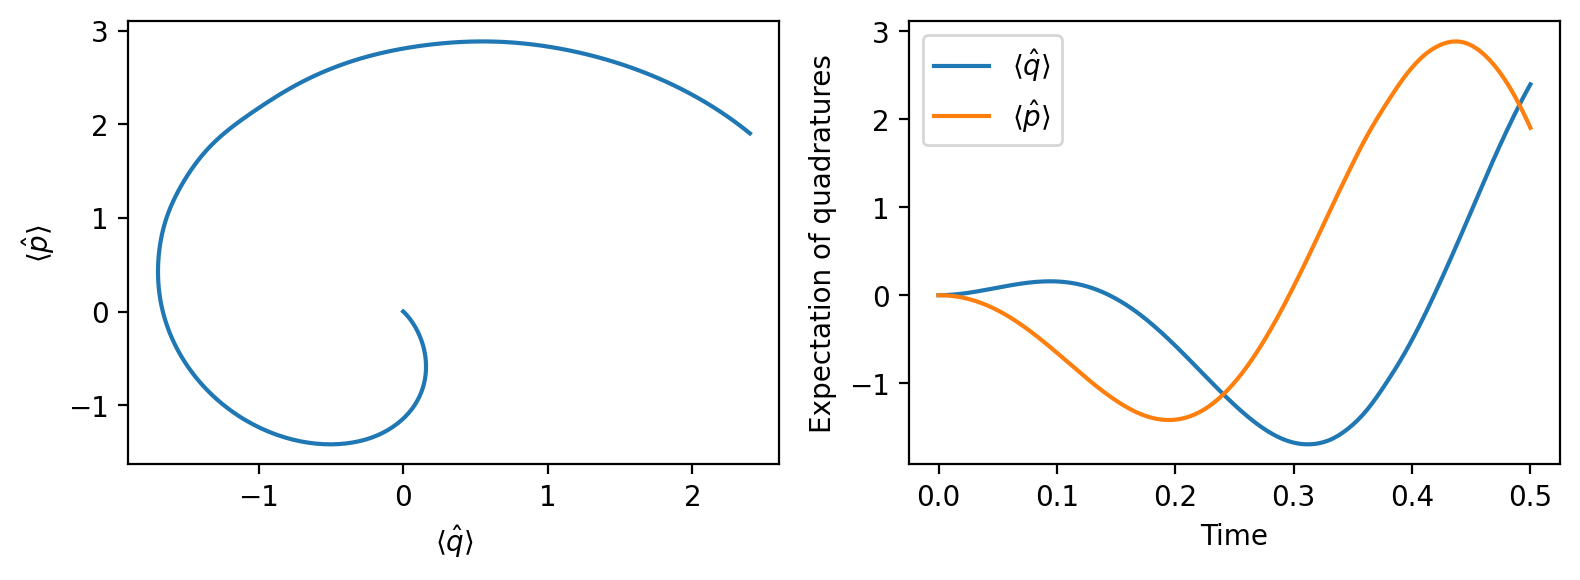

1.9024347204388659


In [19]:
expt = results[0]["aq"]
plot_trajectory(ts, expt)
print(np.imag(expt[-1]))